<a href="https://colab.research.google.com/github/sayan0506/Real-Time-Face-Recognition-Using-Siamese-Network-with-Triplet-Loss-in-Keras/blob/master/Copy_of_Face_Recognizer_using_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Adding Face-Recognition-Master path to the system path
Adding Face-Recognition-Master path to the system path, for accessing necessary modules, else we can't access the cutom modules.

In [ ]:
import sys 

In [ ]:
sys.path.append('/content/gdrive/MyDrive/Face-Recognition-master')

Changing current working directory to /content/gdrive/MyDrive/Face-Recognition-master, if we wouldn't change that, the methods couldn't access the data files stored in the **Face-Recognition-Master** folder

In [ ]:
print('Current working directory becomes')
%cd /content/gdrive/MyDrive/Face-Recognition-master

Current working directory becomes
/content/gdrive/MyDrive/Face-Recognition-master


# Importing Modules

In [ ]:
from keras import backend as K
import time
from multiprocessing.dummy import Pool
K.set_image_data_format('channels_first')
import cv2
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from numpy import genfromtxt
import tensorflow as tf
from fr_utils import *
from inception_network import *
# from face_functions import *
from keras.models import load_model
from keras.utils.vis_utils import plot_model
# to obtain the encoding of the extracted faces
from fr_utils import img_to_encoding

# modules for accessing local webcam in collab
import capture_photo

# for  extracting faces from images
import face_data_generator

# Defining the Triplet loss function

Triplet loss is used as cost function while compiling the Siamese network

In [13]:
def triplet_loss_function(y_true,y_pred,alpha = 0.3):
	# reference image encoding
	anchor = y_pred[0]
	# positive encoding
	positive = y_pred[1]
	# negative encoding
	negative = y_pred[2]
	# calculating positive and negtive distances
	pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
	neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
	basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
	# triplet loss
	loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
	return loss

# Compiling the model

In [14]:
# model object is instantiated with input layer shape
# nh = nw = 96, nc = 3
model = model(input_shape = (3,96,96))
# compiling the model, with 'Adam' optimizer, and loss = triplet
model.compile(optimizer = 'adam', loss = triplet_loss_function, metrics = ['accuracy'])

# Transfer Learning


* Loading weights from trained **Facenet model**

  Here, we are loading the weights of trained **Facenet model**, which is referenced and stored in 'weights' folder in the path '/content/gdrive/MyDrive/Face-Recognition-master'. So, we changed the current working directory 

* Loading the weights

  The weights of the pretrained model is stored in the weights folder of current loation. The weights are being loaded in the network architecture.

In [15]:
load_weights_from_FaceNet(model)

In [ ]:
print('Weights are loaded successfully')

Weights are loaded successfully


In [ ]:
print('Model summary')
#model.summary()
#plot_model(model)

Model summary


In [ ]:
print("Total Parameters of the model:", model.count_params())

Total Parameters of the model: 3743280


# Add facial images to the Database

1. Connecting collab environment with the local webcam.
2. A JS code is used to capture images of each person, when person is present infront of webcam, by pressing the capture button image is stored.
3. If a single face is detected in the image, then it's the valid entry
4. After capturing each image the face is cropped by **frontal_face_detector**, then using **68 facial landmark detction** of that face, and face_utils, dlib library face is aligned.
4. 10 sample faces of each person will be stored in the **facial_images** folder, with each of person_name.



In [ ]:
# Adding faces of person to database
''' 
def add_faces(person):
  # path of images
  path = 'Facial_images'
  # checking whether any folder with that person exista or not
  directory = os.path.join(path, person)
  if not os.path.exists(directory):
    os.makedirs(directory, exist_ok = True)
    print('no')
  # max 10 samples of each person is stored
  MAX_NUMBER_IMAGES = 2
  # counts number of images captured
  count = 0
  while count < MAX_NUMBER_IMAGES:
    filename = person+'.jpg'
    capture_photo.take_photo(filename)
    plt.imshow(plt.imread(filename))
    f_align = face_extraction.face_extraction(img)
    cv2.imwrite(os.path.join(directory, str(person + str(count))+'.jpg'), f_align)
    count = count + 1
    print(count)
'''

"\n# add faces to the database    \ndef add_faces(person):\n  # path of images\n  path = 'Facial_images'\n  # checking whether any folder with that person exista or not\n  directory = os.path.join(path, person)\n  if not os.path.exists(directory):\n    os.makedirs(directory, exist_ok = True)\n    print('no')\n  # max 10 samples of each person is stored\n  MAX_NUMBER_IMAGES = 2\n  # counts number of images captured\n  count = 0\n  while count < MAX_NUMBER_IMAGES:\n    filename = person+'.jpg'\n    capture_photo.take_photo(filename)\n    plt.imshow(plt.imread(filename))\n    f_align = face_extraction.face_extraction(img)\n    cv2.imwrite(os.path.join(directory, str(person + str(count))+'.jpg'), f_align)\n    count = count + 1\n    print(count)\n"

In [36]:
while True:
  person = input("Enter person Name: ")
  face_data_generator.add_faces(person)
  if int(input('Press 1 to proceed with another person, 0 to exit'))==0:
    break
# add_to_database(name)

Enter person Name: Sayan
no


<IPython.core.display.Javascript object>

Image count: 1


<IPython.core.display.Javascript object>

Image count: 2
Press 1 to proceed with another person, 0 to exit1
Enter person Name: Halu
no


<IPython.core.display.Javascript object>

Image count: 1


<IPython.core.display.Javascript object>

Image count: 2
Press 1 to proceed with another person, 0 to exit1
Enter person Name: didi
no


<IPython.core.display.Javascript object>

Image count: 1


<IPython.core.display.Javascript object>

Image count: 2
Press 1 to proceed with another person, 0 to exit0


# Data Visualization

Sample faces of max 5 persons


<Figure size 360x360 with 0 Axes>

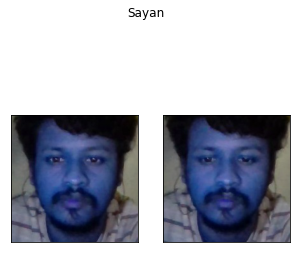

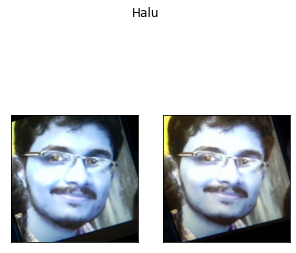

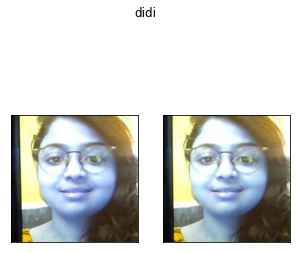

In [47]:
print('Sample faces of max 5 persons')

for c, name in enumerate(os.listdir(path)):
  fig = plt.figure(figsize=(5,5))
  fig.suptitle(name)
  if c<5:
    for i, image in enumerate(os.listdir(os.path.join(path, name))):
      fig.add_subplot(1, len(os.listdir(os.path.join(path, name))), i+1)
      plt.imshow(plt.imread(os.path.join(path, name, image)))
      plt.xticks([])
      plt.yticks([])
    plt.show()


# Obtaining Image Encoding

Creating dictionary to store the encoding array of the faces stored in the datavase, using the Siamese Network

In [50]:
# Facial dictionary to store the encoding of the faces
face_database = {}
# path of the facial images
path = 'Facial_images'
for name in os.listdir(path):
  for image in os.listdir(os.path.join(path, name)):
    # extracting only the filename( splitting .jpg from file name)
    identity = os.path.splitext(os.path.basename(image))[0]
    face_database[identity] = fr_utils.img_to_encoding(os.path.join(path, name, image), model)

print(f'The encoded facial database shape\n {len(face_database)}')

The encoded facial database shape
 6


# Facial Recognition

In [86]:
filename = 'frame.jpg'
capture_photo.take_photo(filename= filename)

<IPython.core.display.Javascript object>

'frame.jpg'

In [87]:
    
def img_to_encoding1(image, model):
  # image = cv2.imread(image_path, 1)
  image = cv2.resize(image, (96, 96)) 
  img = image[...,::-1]
  img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
  x_train = np.array([img])
  embedding = model.predict_on_batch(x_train)
  return embedding


Sayan0 1.079145
Sayan0 1.079145
Halu0 0.9830506
Halu1 0.9287347
Halu1 0.9287347
Halu1 0.9287347
Sayan0 1.1402235
Sayan0 1.1402235
Halu0 0.99066603
Halu1 0.96329707
didi0 0.9540676
didi1 0.95046896
Sayan0 0.80995554
Sayan1 0.76799786
Halu0 0.61878777
Halu1 0.59444946
Halu1 0.59444946
Halu1 0.59444946


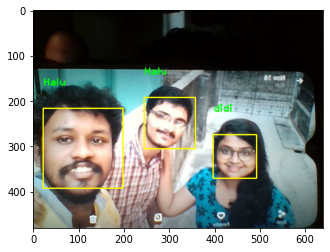

In [92]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

img = plt.imread(filename)
frame = cv2.flip(img, 1)
faces = face_cascade.detectMultiScale(frame, 1.3, 5)
for (x, y, w, h) in faces:
  cv2.rectangle(frame, (x,y), (x+w, y+h), (255,255,0), 2)
  roi = frame[y:y+h, x:x+w]
  encoding = img_to_encoding1(roi, model)
  min_dist = 100

  for (name, encoded_image_name) in face_database.items():
    dist = np.linalg.norm(encoding - encoded_image_name)
    if (dist < min_dist):
      min_dist = dist
      identity = name
    print(identity, min_dist)  
  # print(f'Min dist: {min_dist}')
  # print(name[:-1])
  if min_dist < 1:
    cv2.putText(frame, identity[:-1], (x, y-50), cv2.FONT_HERSHEY_PLAIN, 1.5, (0,255,0), 2)
    #cv2.putText(frame, "Dist : "+str(min_dist), (x, y-50), cv2.FONT_HERSHEY_PLAIN, 1.5, (0,255,0), 2)

plt.imshow(frame)